# Is it a moth?

> #### This notebook is copied and edited from Jeremy Howard's [Is it a bird?](https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data) kaggle exercise

### **Aim:** 
To be able to build a basic image classifier that distiguishes moths and butterflies

### **Background:** 
([Source](https://a-z-animals.com/blog/moth-vs-butterfly-the-8-key-differences/))
Some general info that helps us visually compare moths to butterflies...

- **Wings:** 
    - Moths land with wings spread. They also rest with their wings open.
    - Butterflies land with wings folded back. Their wings are closed when at rest.

- **Antenna:**
    - Moths have a short feathery antenna. Often with a sawed edge. You can find moths with an antenna similar to the butterfly but you won’t find butterflies with a feathery antenna.
    - Butterflies have thin, long antennas. Almost club-shaped with a bulb and shaft at the end.

- **Body shape:**
    - Moths are shorter than butterflies, have thicker hair and their bodies are fatter.
    - Butterfly bodies are skinner and, longer, and their bodies, compared to the moth, tend to be longer as well.

- **Pupa Stage:**
    - Moths create a silky cocoon. But not all moths follow this fashion. One example is the tomato hornworm. It designs a pupation chamber in the ground.
    - Butterflies make a shiny chrysalis. The shell tends to be hard, silkless, and smooth.

In [1]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [2]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
dask-cudf 21.10.1 requires cupy-cuda114, which is not installed.
beatrix-jupyterlab 3.1.6 requires google-cloud-bigquery-storage, which is not installed.
tensorflow 2.6.2 requires numpy~=1.19.2, but you have numpy 1.20.3 which is incompatible.
tensorflow 2.6.2 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow 2.6.2 requires typing-extensions~=3.7.4, but you have typing-extensions 3.10.0.2 which is incompatible.
tensorflow 2.6.2 requires wrapt~=1.12.1, but you have wrapt 1.13.3 which is incompatible.
tensorflow-transform 1.5.0 requires absl-py<0.13,>=0.9, but you have absl-py 0.15.0 which is incompatible.
tensorflow-tran

Basic steps:

1. Use DuckDuckGo to search for images of "bird photos"
1. Use DuckDuckGo to search for images of "forest photos"
1. Fine-tune a pretrained neural network to recognise these two groups
1. Try running this model on a picture of a bird and see if it works.

## Step 1: Download images of moths and butterflies

In [3]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [4]:
from fastdownload import download_url
from fastai.vision.all import *

Searching for 'moth photos'


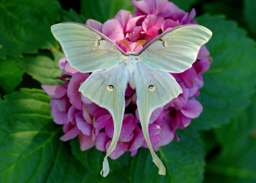

In [5]:
download_url(search_images('moth photos', max_images=1)[0], 'moth.jpg', show_progress=False)
Image.open('moth.jpg').to_thumb(256,256)

Searching for 'butterfly photos'


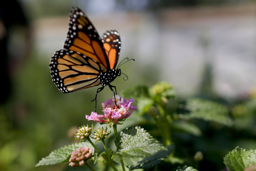

In [6]:
download_url(search_images('butterfly photos', max_images=1)[0], 'butterfly.jpg', show_progress=False)
Image.open('butterfly.jpg').to_thumb(256,256)

In [7]:
searches = 'butterfly','moth'
path = Path('moth_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'butterfly photo'
Searching for 'butterfly sun photo'
Searching for 'butterfly shade photo'
Searching for 'moth photo'
Searching for 'moth sun photo'
Searching for 'moth shade photo'


## Step 2: Train our model

Removing images that might not download correctly:

In [8]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

1

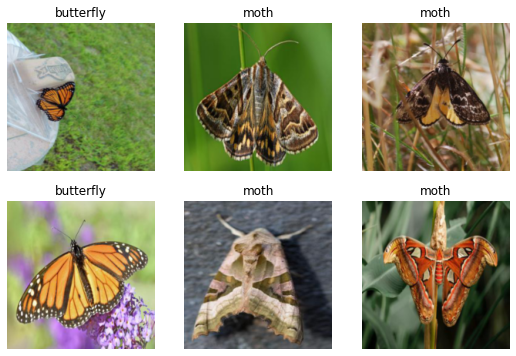

In [9]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6) # showing sample images

DataBlock parameters:

- `blocks=(ImageBlock, CategoryBlock)`: The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

- `get_items=get_image_files`: To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

- `splitter=RandomSplitter(valid_pct=0.2, seed=42)`: Split the data into training and validation sets randomly, using 20% of the data for the validation set.

- `get_y=parent_label`: The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

- `item_tfms=[Resize(192, method='squish')]`: Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it)

`fine_tune()` method automatically uses best practices for fine tuning a pre-trained model

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pre-trained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

In [10]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.455209,1.527200,0.294118,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.361255,0.627652,0.147059,00:01
1,0.266077,0.414625,0.147059,00:01
2,0.197070,0.345900,0.088235,00:01


## Step 3: Predictions

In [11]:
is_moth,_,probs = learn.predict(PILImage.create('moth.jpg'))
print(f"This is a: {is_moth}.")
print(f"Probability it's a moth: {probs[0]:.4f}")

This is a: butterfly.
Probability it's a moth: 0.8482


In [12]:
is_butterfly,_,probs = learn.predict(PILImage.create('butterfly.jpg'))
print(f"This is a: {is_butterfly}.")
print(f"Probability it's a butterfly: {probs[0]:.4f}")

This is a: butterfly.
Probability it's a butterfly: 0.9994
